In [1]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
NUM_CLASSES  = 5
# NUM_CLASSES  = 3  # 2 stage models
CHANNEL_SIZE = 3

# pre_process = str(IMG_DIM) + "_ben_normal_"

pre_process = str(IMG_DIM) + "_ben_weird_"

# pre_process = str(IMG_DIM) + "_clahe_"


Using TensorFlow backend.
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python

# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

In [4]:
# data frame of current competition
df_2019 = pd.read_csv("../aptos2019/train.csv") 
df_2019.processed = df_2019.id_code.apply(lambda x: pre_process + x + ".png")
df_2019["original"]  = df_2019.id_code.apply(lambda x: x + ".png")
df_2019["processed"] = df_2019.original.apply(lambda x: pre_process + x)
# train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False) not for python 3.5
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, random_state=42)

# 2019 data frame 
df_2015 = pd.read_csv("../aptos2015/trainLabels.csv") 
df_2015["original"]  = df_2015.image.apply(lambda x: x + ".jpeg")
df_2015["processed"] = df_2015.original.apply(lambda x: pre_process + x)
df_2015["diagnosis"] = df_2015.level
# train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, random_state=42)

valid_2019['diagnosis'].value_counts().plot(kind='bar')
print(valid_2019[:3])
plt.title('Samples Per Class')


           id_code  diagnosis          original  \
2059  90960ddf4d14          0  90960ddf4d14.png   
1105  4e0656629d02          1  4e0656629d02.png   
818   3b018e8b7303          3  3b018e8b7303.png   

                           processed  
2059  256_ben_weird_90960ddf4d14.png  
1105  256_ben_weird_4e0656629d02.png  
818   256_ben_weird_3b018e8b7303.png  


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Samples Per Class')

In [5]:
def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    return y_val

def get_train_valid_df(year="2019", style="normal", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    if style == "normal":
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x+1)])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x+1)])
    elif style == "stage_1":
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(min(x+1, 3))])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(min(x+1, 3))])
    elif style == "stage_2":
#         train = train[train.diagnosis != 0]
#         train = train[train.diagnosis != 1]
#         valid = valid[valid.diagnosis != 0]
#         valid = valid[valid.diagnosis != 1]
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(max(x-1, 1))])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(max(x-1, 1))])
    else:
        print("Error: " + style + " style not implemented.")
        exit()

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())
        
        for diagnosis in range(0 if style != "stage_2" else 0, 5):
            indexes_train = train[train['diagnosis'] == diagnosis].index
            indexes_valid = valid[valid['diagnosis'] == diagnosis].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution, also decrease the overall amount to a max of 4,000 
    # with a prop drop in valid
    
    frac = 1
    if train.index.size > 5000:
        frac = 5000/train.index.size
        print(frac)
    train = train.sample(frac=frac)
    valid = valid.sample(frac=frac)
    
    return train, valid

df_sample, _ = get_train_valid_df(year="2019", style="stage_2")
print(df_sample.head())

           id_code  diagnosis          original  \
957   4489d421e5aa          2  4489d421e5aa.png   
1894  8596a24a14bd          4  8596a24a14bd.png   
3552  f72adcac5638          4  f72adcac5638.png   
1500  697538183db5          3  697538183db5.png   
312   17d7d6b092f4          0  17d7d6b092f4.png   

                           processed     labels  
957   256_ben_weird_4489d421e5aa.png        [0]  
1894  256_ben_weird_8596a24a14bd.png  [0, 1, 2]  
3552  256_ben_weird_f72adcac5638.png  [0, 1, 2]  
1500  256_ben_weird_697538183db5.png     [0, 1]  
312   256_ben_weird_17d7d6b092f4.png        [0]  


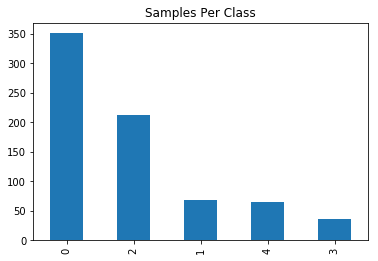

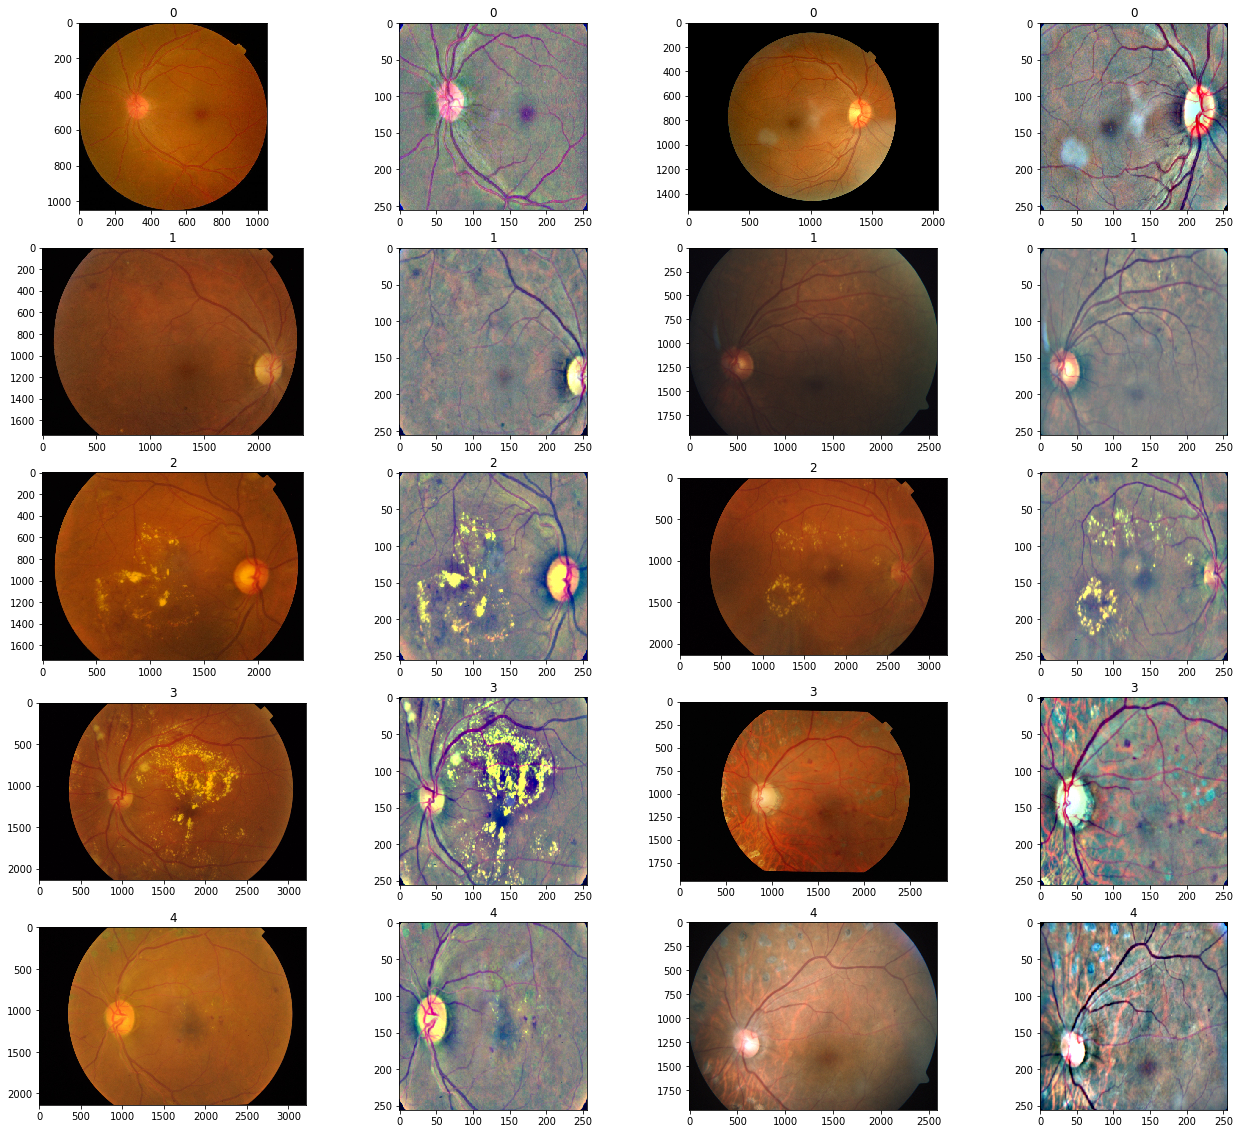

In [6]:
# display some data
def display_data():
    df_example, _ = get_train_valid_df(year="2019")

    # Display some random images from Data Set with class categories.
    figure=plt.figure(figsize=(22,20))
    for target_class in range(5):
        for i, file_name in enumerate(df_example[df_example.diagnosis == target_class].original.sample(2)):
            
            # open the file
            o_img = cv2.imread("../aptos2019/train_images/" + file_name)
            p_img = cv2.imread("../aptos2019/train_images/" + pre_process + file_name)

            o_rgb = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
            p_rgb = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
            plt.imshow(o_rgb)
            ax.set_title(target_class)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
            plt.imshow(p_rgb)
            ax.set_title(target_class)
    
    plt.show()
            
display_data()

In [7]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True and (jitter > 0.01), 
                                       vertical_flip=True and (jitter > 0.01),
                                       rotation_range=int(600*jitter),
                                       brightness_range=[1-jitter/3, 1+jitter/3],
                                       channel_shift_range=int(30*jitter),
                                       zoom_range=[max(0.9, 1-5*jitter), 1],
                                       fill_mode="mirror",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="processed", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True, style="normal"):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib, style=style) 
    datagen_jittered = dataGenerator(jitter)
    datagen_clean = dataGenerator(0.02)
    
    train_gen = datagen_with_flow(datagen_jittered, train, "../aptos" + year + "/train_images/")
    valid_gen = datagen_with_flow(datagen_clean, valid, "../aptos" + year + "/train_images/")
    
    return train_gen, valid_gen

gc.collect()


41335

Found 785 validated image filenames belonging to 5 classes.
Found 181 validated image filenames belonging to 5 classes.


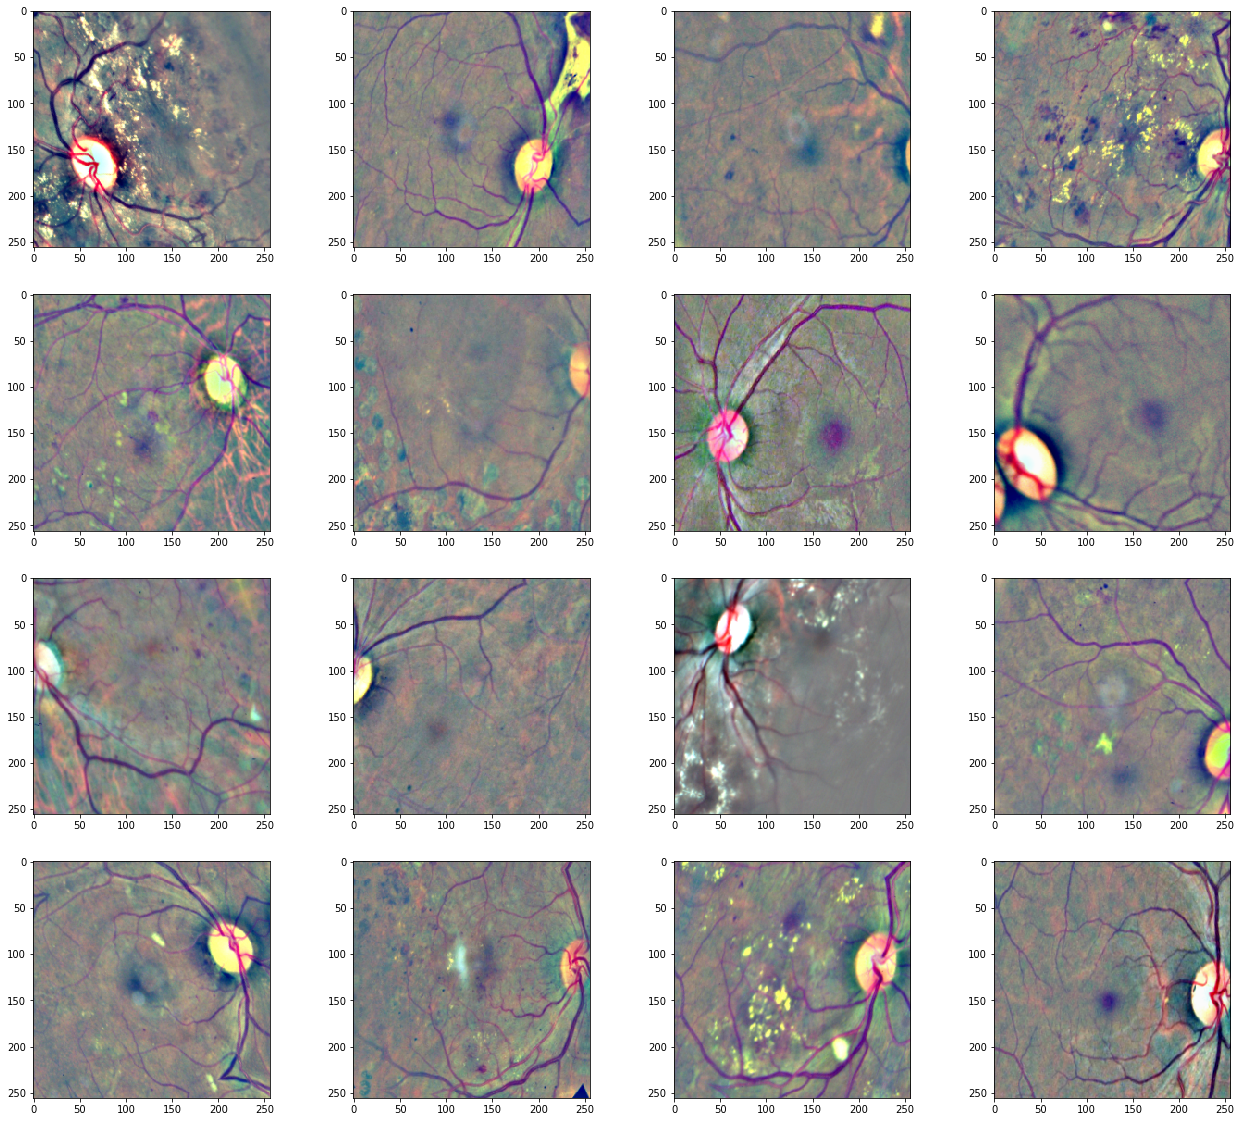

In [8]:
train_sample_gen, valid_sample_gen = generator(jitter=0.05, style="normal")

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in train_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break
plt.show()

In [9]:
class Metrics(Callback):
    def __init__(self, generator, style):
        self.style = style
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 20
        y_pred     = []
        y_val      = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            y_pred.extend(label_convert(predictions > 0.5))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(confusion_matrix(y_val, y_pred), val_kappa)
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.88:
#         if val_kappa == max(self.val_kappas) and val_kappa > 0.85:
            gc.collect()
            print("Max of this run, saving model.")
            model.save(self.style + "_" + str(val_kappa) + ".h5")


In [10]:
def create_model():
    
    model = Sequential()
#     model.add(DenseNet121(weights='../DenseNet-BC-121-32-no-top.h5', 
    model.add(DenseNet121(weights=None, 
                          include_top=False, 
                          input_shape=(IMG_DIM, IMG_DIM, CHANNEL_SIZE)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

model = create_model()



In [27]:
# model.load_weights("normal_0.9138864018922975.h5")

In [11]:

model.load_weights("normal_0.9043895887598602.h5")
for style in ["normal"]:
    for year in [ "2015", "2015", "2019"]:
        lr = 0.00002
        for jitter in [0.5, 0.3, 0.1, 0.05]:
            lr *= 0.8
            model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy',  metrics=['accuracy'])
            # started at 0.00003. Seems to still change somewhat with even 0.000005

            print("           -----------------------------------", year, 
                  jitter, "-----------------------------------")

            for even_distrib in [True, True, True, False]:

                print("           -   -   -   -   -   -   -   -   ", 
                      even_distrib, "-   -   -   -   -   -   -   -   -")

                # these need to be global for the kappa callback
                train_generator, valid_generator = generator(jitter=jitter, 
                                                             year=year, 
                                                             even_distrib=even_distrib, 
                                                             style=style)

                # Call backs during training            
                kappa_callbacks = Metrics(valid_generator, style)
                reduce_lr  = ReduceLROnPlateau(monitor='val_loss', 
                                               min_delta=0.0004, 
                                               patience=2, 
                                               min_lr=1e-8, 
                                               mode='auto', verbose=1)

                # train the model for 12 epochs
                history = model.fit_generator(generator=train_generator,
                                              steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                              validation_data=valid_generator,
                                              validation_steps=valid_generator.n // valid_generator.batch_size,
                                              epochs=2, workers=4, verbose=1,
                                              callbacks=[reduce_lr, kappa_callbacks],
                                             )

            gc.collect()
            model.save(style + year + str(jitter) + ".h5")

           ----------------------------------- 2015 0.5 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1794 validated image filenames belonging to 5 classes.
Found 479 validated image filenames belonging to 5 classes.


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1021 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 246 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/2
56/56 [==============================] - 103s 2s/step - loss: 0.5143 - acc: 0.8365 - val_loss: 0.5992 - val_acc: 0.8371
[[98 24  2  0  0]
 [88 27  9  0  1]
 [35 45 55  3  0]
 [ 7 11 63 36  7]
 [ 4 16 28 26 54]] 0.6771519247603683
Epoch 2/2
56/56 [==============================] - 90s 2s/step - loss: 0.3096 - acc: 0.8772 - val_loss: 0.3370 - val_acc: 0.8711
[[74 52  3  0  0]
 [42 69  5  0  1]
 [22 47 62  7  0]
 [ 0 12 47 66  9]
 [ 2 12 18 28 61]] 0.7463073002312646
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1788 validated image filenames belonging to 5 classes.
Found 498 validated image filenames belonging to 5 classes.
Epoch 1/2


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1027 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 227 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


55/55 [==============================] - 92s 2s/step - loss: 0.2919 - acc: 0.8791 - val_loss: 0.2874 - val_acc: 0.8858
[[68 54  4  2  0]
 [49 63  5  2  2]
 [ 8 52 59 17  3]
 [ 1 12 35 69  7]
 [ 2  5  9 37 61]] 0.7712067193975712
Epoch 2/2
55/55 [==============================] - 91s 2s/step - loss: 0.2746 - acc: 0.8856 - val_loss: 0.2507 - val_acc: 0.8867
[[58 68  7  1  0]
 [39 80  7  2  1]
 [ 9 32 67 22  4]
 [ 0  8 20 77  8]
 [ 0  3 15 31 67]] 0.8027686774198046
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1000 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 255 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1815 validated image filenames belonging to 5 classes.
Found 470 validated image filenames belonging to 5 classes.
Epoch 1/2
56/56 [==============================] - 93s 2s/step - loss: 0.2710 - acc: 0.8866 - val_loss: 0.2443 - val_acc: 0.8920
[[42 72  5  0  0]
 [25 83 17  1  3]
 [ 6 47 38 33  3]
 [ 0 10 20 87  6]
 [ 0  2  9 46 75]] 0.8037930145547527
Epoch 2/2
56/56 [==============================] - 91s 2s/step - loss: 0.2610 - acc: 0.8881 - val_loss: 0.2420 - val_acc: 0.8922
[[46 75  3  0  0]
 [19 86 18  3  0]
 [ 4 47 42 34  3]
 [ 0  9 23 92  4]
 [ 0  3 10 39 70]] 0.8126503064311759
           -   -   -   -   -   -   -   -    False -   -   -   -   -   -   -   -   -
0.17793594306049823


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1756 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 461 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3244 validated image filenames belonging to 5 classes.
Found 789 validated image filenames belonging to 5 classes.
Epoch 1/2
101/101 [==============================] - 165s 2s/step - loss: 0.2192 - acc: 0.9028 - val_loss: 0.4123 - val_acc: 0.8695
[[259 133  45  17   7]
 [ 12  22   7   2   0]
 [  8  22  47  19   5]
 [  0   1   5  11   0]
 [  0   1   2   7   8]] 0.5373856912318451
Epoch 2/2
101/101 [==============================] - 164s 2s/step - loss: 0.1548 - acc: 0.9396 - val_loss: 0.1942 - val_acc: 0.9326
[[387  50  22   0   1]
 [ 27  11   4   0   0]
 [ 14  20  54   8   0]
 [  1   0   8   8   1]
 [  0   1   3   5   4]] 0.7272427518311783
           ----------------------------------- 2015 0.3 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1797 validated image filenames belonging to 5 classes.
Found 482 validated image filenames belonging to 5 classes.


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1018 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 243 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/2
56/56 [==============================] - 103s 2s/step - loss: 0.4129 - acc: 0.8396 - val_loss: 0.4273 - val_acc: 0.8396
[[106   2   0   0   0]
 [116  11   2   0   0]
 [ 51  22  51   8   0]
 [  8   9  55  54   2]
 [  6   4  17  39  47]] 0.7135820272381398
Epoch 2/2
56/56 [==============================] - 91s 2s/step - loss: 0.2600 - acc: 0.8896 - val_loss: 0.3069 - val_acc: 0.8769
[[98  9  4  0  0]
 [79 29 12  0  0]
 [33 20 48 27  0]
 [ 6  2 29 77  7]
 [ 1  4 19 40 66]] 0.7841972966803173
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1976 validated image filenames belonging to 5 classes.
Found 508 validated image filenames belonging to 5 classes.
Epoch 1/2


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 839 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 217 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


61/61 [==============================] - 100s 2s/step - loss: 0.2645 - acc: 0.8887 - val_loss: 0.2617 - val_acc: 0.8854
[[105  20   7   0   1]
 [ 62  48  18   2   0]
 [ 18  23  46  26   5]
 [  0   7  35  80   6]
 [  2   2  13  40  70]] 0.807256039483938
Epoch 2/2
61/61 [==============================] - 100s 2s/step - loss: 0.2600 - acc: 0.8866 - val_loss: 0.2622 - val_acc: 0.8945
[[104  19  11   0   1]
 [ 43  63  22   1   0]
 [ 15  32  50  30   2]
 [  4   5  26  78   8]
 [  0   5   8  36  73]] 0.8100098871670534
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 698 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 176 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2117 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Epoch 1/2
66/66 [==============================] - 108s 2s/step - loss: 0.2451 - acc: 0.8940 - val_loss: 0.2632 - val_acc: 0.8871
[[83 30 11  0  3]
 [50 42 26  2  0]
 [12 22 52 34  4]
 [ 0  9 24 77  9]
 [ 0  3  9 36 75]] 0.7972161433151814
Epoch 2/2
66/66 [==============================] - 107s 2s/step - loss: 0.2451 - acc: 0.8909 - val_loss: 0.2341 - val_acc: 0.8948
[[69 44 10  1  2]
 [42 61 18  1  0]
 [ 6 40 57 28  2]
 [ 0  8 27 66 12]
 [ 0  2 11 36 70]] 0.8015272464038592
           -   -   -   -   -   -   -   -    False -   -   -   -   -   -   -   -   -
0.17793594306049823
Found 4077 validated image filenames belonging to 5 classes.
Found 1004 validated image filenames belonging to 5 classes.
Epoch 1/2


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 923 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


127/127 [==============================] - 207s 2s/step - loss: 0.2017 - acc: 0.9137 - val_loss: 0.3278 - val_acc: 0.8921
[[334  72  49  10   8]
 [ 24  17   7   1   2]
 [ 10  15  42  17   1]
 [  0   1   5   7   1]
 [  0   0   3   8   6]] 0.5573684007360037
Epoch 2/2
127/127 [==============================] - 205s 2s/step - loss: 0.1531 - acc: 0.9423 - val_loss: 0.1600 - val_acc: 0.9412
[[390  46  11   0   0]
 [ 29   7   7   0   0]
 [ 26  12  51   5   0]
 [  0   1  14   6   0]
 [  0   0   6   2   7]] 0.7455978070818621
           ----------------------------------- 2015 0.1 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 2610 validated image filenames belonging to 5 classes.
Found 669 validated image filenames belonging to 5 classes.


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 205 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 56 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/2
81/81 [==============================] - 147s 2s/step - loss: 0.3865 - acc: 0.8485 - val_loss: 0.3427 - val_acc: 0.8516
[[121   1   1   0   0]
 [106  17   6   0   1]
 [ 42  22  52   9   1]
 [ 12   4  58  52   4]
 [ 12   2  21  42  54]] 0.7021820154333409
Epoch 2/2
81/81 [==============================] - 132s 2s/step - loss: 0.2635 - acc: 0.8913 - val_loss: 0.2522 - val_acc: 0.8870
[[108  16   3   0   0]
 [ 73  40  11   0   0]
 [ 20  25  53  28   1]
 [  4   6  26  82   7]
 [  2   5  15  43  69]] 0.8054686457911623
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -


/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 5 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 3 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2810 validated image filenames belonging to 5 classes.
Found 722 validated image filenames belonging to 5 classes.
Epoch 1/2
87/87 [==============================] - 144s 2s/step - loss: 0.2554 - acc: 0.8916 - val_loss: 0.2513 - val_acc: 0.8855
[[93 30  2  0  2]
 [67 51 10  2  0]
 [12 34 45 31  4]
 [ 2  8 31 78  6]
 [ 1  4 18 40 69]] 0.7938789761371572
Epoch 2/2
87/87 [==============================] - 143s 2s/step - loss: 0.2481 - acc: 0.8917 - val_loss: 0.2409 - val_acc: 0.8977
[[87 33  3  1  1]
 [49 55 17  0  0]
 [ 8 32 48 37  4]
 [ 1  8 20 92  3]
 [ 1  0 15 43 68]] 0.8216130225578455
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 2815 validated image filenames belonging to 5 classes.
Found 725 validated image filenames belonging to 5 classes.
Epoch 1/2
87/87 [==============================] - 144s 2s/step - loss: 0.2433 - acc: 0.8949 - val_loss: 0.2390 - val_acc: 0.8989
[[88 31  6  0  1]
 [48 65 10  3  0]
 [15 32 48 32  2]
 [ 1  8 28 

/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 4999 validated image filenames belonging to 5 classes.
Found 1250 validated image filenames belonging to 5 classes.
Epoch 1/2
156/156 [==============================] - 256s 2s/step - loss: 0.1952 - acc: 0.9178 - val_loss: 0.2394 - val_acc: 0.9178
[[366  67  50   1   0]
 [ 20  11   7   1   0]
 [ 13  20  41  15   1]
 [  0   0   6   6   1]
 [  0   0   3   6   5]] 0.6532804647517174
Epoch 2/2
156/156 [==============================] - 254s 2s/step - loss: 0.1574 - acc: 0.9382 - val_loss: 0.1460 - val_acc: 0.9414
[[404  23  13   1   0]
 [ 30  11   7   0   0]
 [ 23  11  57   4   1]
 [  2   0   3  10   2]
 [  1   0   0   2   5]] 0.7409875229803
           ----------------------------------- 2015 0.05 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 2815 validated image filenames belonging to 5 classes.
Found 724 validated image filenames belonging to 5 classes.
Epoch 1/2
87/87 [==============================] -

87/87 [==============================] - 145s 2s/step - loss: 0.2236 - acc: 0.9016 - val_loss: 0.2424 - val_acc: 0.8960
[[87 30  7  0  2]
 [54 68 10  0  0]
 [16 42 46 19  3]
 [ 2  6 32 77  6]
 [ 0  1 12 37 83]] 0.8201334493762692
Epoch 2/2
87/87 [==============================] - 143s 2s/step - loss: 0.2181 - acc: 0.8988 - val_loss: 0.2613 - val_acc: 0.8910
[[76 39  6  1  1]
 [45 67 11  0  1]
 [21 34 50 16  2]
 [ 2  8 25 83  9]
 [ 0  4 15 33 79]] 0.7970794358342207
           -   -   -   -   -   -   -   -    False -   -   -   -   -   -   -   -   -
0.17793594306049823
Found 4999 validated image filenames belonging to 5 classes.
Found 1250 validated image filenames belonging to 5 classes.
Epoch 1/2
156/156 [==============================] - 256s 2s/step - loss: 0.1836 - acc: 0.9249 - val_loss: 0.1915 - val_acc: 0.9208
[[404  39  28   1   0]
 [ 23   6   7   0   0]
 [ 14  17  53  14   1]
 [  1   0  12   5   0]
 [  0   0   2   4   9]] 0.752546446795516
Epoch 2/2
156/156 [===================

24/24 [==============================] - 39s 2s/step - loss: 0.2204 - acc: 0.9045 - val_loss: 0.2214 - val_acc: 0.9163
[[116   6   0   0   0]
 [ 12  40  70   1   0]
 [  0   4  72  38   0]
 [  0   0  19  88  20]
 [  0   1  22  53  45]] 0.8548301708250559
Epoch 2/2
24/24 [==============================] - 38s 2s/step - loss: 0.2076 - acc: 0.9121 - val_loss: 0.2259 - val_acc: 0.9060
[[112   9   0   0   0]
 [ 19  42  61   1   0]
 [  0   6  94  25   0]
 [  0   0  22  73  18]
 [  0   4  24  52  45]] 0.8423696637195613
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 785 validated image filenames belonging to 5 classes.
Found 181 validated image filenames belonging to 5 classes.
Epoch 1/2
24/24 [==============================] - 39s 2s/step - loss: 0.1953 - acc: 0.9204 - val_loss: 0.2023 - val_acc: 0.9162
[[117   0   0   0   0]
 [ 14  59  50   0   1]
 [  0   9  74  41   0]
 [  0   0  21  83  16]
 [  0   0  20  55  47]] 0.8675618405919834
Epoch 2/2
24/24

Epoch 1/2
24/24 [==============================] - 62s 3s/step - loss: 0.1491 - acc: 0.9389 - val_loss: 0.2033 - val_acc: 0.9212
[[116   7   0   0   0]
 [  8  73  30   1   3]
 [  0   3 101  19   0]
 [  0   0  32  66  23]
 [  0   4  30  39  52]] 0.8453181567878525
Epoch 2/2
24/24 [==============================] - 38s 2s/step - loss: 0.1417 - acc: 0.9424 - val_loss: 0.1999 - val_acc: 0.9141
[[113   7   0   0   0]
 [  5  84  36   0   2]
 [  0  10  85  22   1]
 [  0   0  35  66  17]
 [  0   3  20  51  50]] 0.8591930051524547
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 785 validated image filenames belonging to 5 classes.
Found 181 validated image filenames belonging to 5 classes.
Epoch 1/2
24/24 [==============================] - 39s 2s/step - loss: 0.1404 - acc: 0.9436 - val_loss: 0.1994 - val_acc: 0.9213
[[122   3   0   0   0]
 [  5  82  25   1   4]
 [  0   7  90  17   7]
 [  0   1  29  73  19]
 [  0   3  26  37  56]] 0.8501846802988365
Epoch

In [29]:
def prediction_convert(predictions, thresholds):
    
    thresholded = np.zeros(predictions.shape)
    
    for i in range(NUM_CLASSES):
        thresholded[:,i] = predictions[:,i] > thresholds[i]
    y_val = thresholded.astype(int).sum(axis=1) - 1
    return y_val

def prediction_convert_highest(predictions, thresholds):
    thresholded = np.zeros(predictions.shape)
    for i in range(NUM_CLASSES):
        thresholded[:,i] = predictions[:,i] > thresholds[i]
        
    y_val = np.zeros((predictions.shape[0]), dtype=np.int)
    for i in range(predictions.shape[0]):
        for j in range(4, -1, -1):
            if thresholded[i][j]:
                y_val[i] = j
                break
    return y_val

def prediction_convert_two_stage(stage_1_preds, stage_2_preds, thresholds):
    
    thresh_1 = np.zeros((stage_1_preds.shape[0], 3))
    thresh_2 = np.zeros((stage_2_preds.shape[0], 3))
    
    for i in range(3):
        thresh_1[:,i] = stage_1_preds[:,i] > thresholds[i]
        thresh_2[:,i] = stage_2_preds[:,i] > thresholds[i+3]
    
    y_val   = thresh_1.astype(int).sum(axis=1) - 1
    y_val_2 = thresh_2.astype(int).sum(axis=1) + 1
    
    for i in range(stage_1_preds.shape[0]):
        if y_val[i] == 2:
            y_val[i] = y_val_2[i]
    return y_val

def find_best_thresholds(stage_1_preds):
    
    y_actual = valid_2019.diagnosis.astype(int).values
    
    gc.collect()
    
    thresholds = [0.5 for i in range(5)]
    d_thresh = 0.25
    
    for sweep in range(len(thresholds)):

        for label in range(len(thresholds)):
            
            currKappa = cohen_kappa_score(y_actual, prediction_convert_highest(stage_1_preds, thresholds), weights='quadratic')
            
            print(currKappa)
            
            thresholds[label] += d_thresh
            kappaUp = cohen_kappa_score(y_actual, prediction_convert_highest(stage_1_preds, thresholds), weights='quadratic')
            
            thresholds[label] -= 2*d_thresh
            kappaDown = cohen_kappa_score(y_actual, prediction_convert_highest(stage_1_preds, thresholds), weights='quadratic')
            
            thresholds[label] += d_thresh
            
            if kappaUp > currKappa:
                thresholds[label] += d_thresh
                print(confusion_matrix(y_actual, prediction_convert_highest(stage_1_preds, thresholds)))
            elif kappaDown > currKappa:
                thresholds[label] -= d_thresh
                print(confusion_matrix(y_actual, prediction_convert_highest(stage_1_preds, thresholds)))
                

        d_thresh /= 2
    
    gc.collect()
    return thresholds

# get the best thresholds (expensive operation, didn't yeild much improvement)
# subset_valid = valid_2019[:]
# subset_valid.diagnosis = valid_2019.diagnosis.astype(str)
# d_gen = dataGenerator().flow_from_dataframe(dataframe=subset_valid, 
#                                             directory="../aptos" + year + "/train_images/", 
#                                             x_col="processed", 
#                                             y_col='diagnosis', 
#                                             target_size=(IMG_DIM, IMG_DIM),
#                                             shuffle=False,
#                                            )

# make test predictions
# stage_1_preds = model.predict_generator(d_gen)
best_thresholds = find_best_thresholds(stage_1_preds)
print(best_thresholds)

# 0.9261811061956504
# [0.5, 0.625, 0.515625, 0.421875, 0.4375]
# 0.9261811061956504
# [0.5, 0.625, 0.515625, 0.421875, 0.4375]

0.916929670624032
0.916929670624032
0.916929670624032
0.916929670624032
0.916929670624032
[[344   7   0   0   0]
 [  2  30  35   1   0]
 [  1  12 179  12   9]
 [  0   1  10  12  13]
 [  0   0  16   7  42]]
0.9170470406277114
0.9170470406277114
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 179  12   9]
 [  0   1  10  12  13]
 [  0   0  16   7  42]]
0.9180122112676208
0.9180122112676208
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 163  28   9]
 [  0   1   7  15  13]
 [  0   0  12  11  42]]
0.9195494048272352
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 164  32   4]
 [  0   1   7  19   9]
 [  0   0  12  20  33]]
0.9211643861659886
0.9211643861659886
0.9211643861659886
0.9211643861659886
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 179  17   4]
 [  0   1   9  17   9]
 [  0   0  14  18  33]]
0.9223969300883381
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 179  19   2]
 [  0   1   9  19   7]
 [  0   0  14  18  33]]
0.9250813895623646
0.925